<a href="https://colab.research.google.com/github/LuoyaoChen/Deep-Learning-Practice-Colab/blob/main/Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("drive/MyDrive/1001FinalProj/data")

# Use new data to do matrix factorization
## source:
https://towardsdatascience.com/recommender-systems-in-python-from-scratch-643c8fc4f704 

In [4]:
import numpy as np
import pandas as pd

In [5]:
newdata = pd.read_csv("merged_train_data_addingfeatures_add_Popularity.csv")

In [42]:
sel_hotel_f_from_yue = ['site_name' ,'posa_continent', 'channel','srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market',   'pca_d1', 'pca_d2', 'pca_d3', 'pca_d4', 'pca_d5', 'pca_d6', 'pca_d7', 'pca_d8', 'pca_d9', 'pca_d10', 'pca_d11', 'pca_d12', 'pca_d13', 'pca_d14', 'pca_d15', 'pca_d16', 'pca_d17', 'pca_d18', 'pca_d19']
sel_user_f_from_yue = [ 'user_location_country','user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'cnt', 'is_holiday','plan_time', 'duration_stay', 'travel_month', 'travel_day', 'travel_single']
sel_f_from_yue = sel_hotel_f_from_yue + sel_user_f_from_yue
# useable_data = newdata[sel_f_from_yue]
useable_data = newdata
useable_data

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,pca_d1,pca_d2,pca_d3,pca_d4,pca_d5,pca_d6,pca_d7,pca_d8,pca_d9,pca_d10,pca_d11,pca_d12,pca_d13,pca_d14,pca_d15,pca_d16,pca_d17,pca_d18,pca_d19,search_checkin_date,search_checkout_date,searching_year,searching_month,travel_year,travel_month,travel_day,duration_stay,plan_time,is_weekend,with_children,travel_single,is_holiday,Popularity
0,0,2013-02-15 13:18:43,2,3,66,462,41898,2716.6746,1482,0,0,1,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,28,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,8,1,0,0,0,5
1,1,2013-02-16 11:57:50,2,3,66,462,41898,2716.5257,1482,0,0,0,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,73,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,7,1,0,0,0,2
2,2,2013-02-16 12:03:45,2,3,66,462,41898,2722.4856,1482,0,0,0,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,26,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,7,1,0,0,0,3
3,3,2013-02-16 12:23:57,2,3,66,462,41898,2716.6746,1482,0,0,0,2013-03-01,2013-03-06,2,0,1,8857,1,0,1,2,50,214,28,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-03-01 00:00:00,2013-03-06 00:00:00,2013,2,2013,3,4,5,12,0,0,0,0,5
4,4,2013-01-14 14:11:50,40,3,66,226,42300,4559.5098,73099,0,0,9,2013-05-25,2013-06-01,2,0,1,8857,1,0,3,2,50,214,92,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-05-25 00:00:00,2013-06-01 00:00:00,2013,1,2013,5,5,7,130,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190591,190591,2014-02-25 15:11:44,2,3,66,462,49272,2080.6120,330610,0,0,3,2014-03-04,2014-03-08,2,0,1,44047,6,0,1,4,8,1532,92,4.525082,6.421489,3.390301,-0.927386,-3.113079,2.224510,0.836370,-1.328418,0.673490,-2.157453,-1.336207,0.004688,-1.223420,-1.497118,0.034862,-1.635106,-0.660517,-1.230124,-0.390200,2014-03-04 00:00:00,2014-03-08 00:00:00,2014,2,2014,3,1,4,6,0,0,0,0,1
190592,190592,2014-02-25 15:15:58,2,3,66,462,49272,2079.2167,330610,0,0,3,2014-03-04,2014-03-08,2,0,1,44047,6,0,1,4,8,1532,92,4.525082,6.421489,3.390301,-0.927386,-3.113079,2.224510,0.836370,-1.328418,0.673490,-2.157453,-1.336207,0.004688,-1.223420,-1.497118,0.034862,-1.635106,-0.660517,-1.230124,-0.390200,2014-03-04 00:00:00,2014-03-08 00:00:00,2014,2,2014,3,1,4,6,0,0,0,0,1
190593,190593,2014-09-03 21:18:38,2,3,66,462,49272,1024.5222,330610,0,0,9,2014-09-11,2014-09-13,1,0,1,34755,4,0,1,2,50,656,91,8.361960,0.484571,-4.940548,0.686526,0.187378,-1.324432,0.695327,0.876695,0.249645,-1.574186,1.935547,-0.349696,-0.203548,-0.134234,-0.185535,-0.229137,0.206385,-0.165811,0.338386,2014-09-11 00:00:00,2014-09-13 00:00:00,2014,9,2014,9,3,2,7,0,0,1,0,5
190594,190594,2014-09-03 23:05:18,2,3,66,462,49272,1025.1472,330610,0,0,9,2014-09-11,2014-09-13,1,0,1,34755,4,0,1,2,50,656,91

In [43]:
useable_data['date']=pd.to_datetime(useable_data["date_time"])
useable_data

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,pca_d1,pca_d2,pca_d3,pca_d4,pca_d5,pca_d6,pca_d7,pca_d8,pca_d9,pca_d10,pca_d11,pca_d12,pca_d13,pca_d14,pca_d15,pca_d16,pca_d17,pca_d18,pca_d19,search_checkin_date,search_checkout_date,searching_year,searching_month,travel_year,travel_month,travel_day,duration_stay,plan_time,is_weekend,with_children,travel_single,is_holiday,Popularity,date
0,0,2013-02-15 13:18:43,2,3,66,462,41898,2716.6746,1482,0,0,1,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,28,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,8,1,0,0,0,5,2013-02-15 13:18:43
1,1,2013-02-16 11:57:50,2,3,66,462,41898,2716.5257,1482,0,0,0,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,73,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,7,1,0,0,0,2,2013-02-16 11:57:50
2,2,2013-02-16 12:03:45,2,3,66,462,41898,2722.4856,1482,0,0,0,2013-02-24,2013-03-01,2,0,1,8857,1,0,1,2,50,214,26,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-02-24 00:00:00,2013-03-01 00:00:00,2013,2,2013,2,6,5,7,1,0,0,0,3,2013-02-16 12:03:45
3,3,2013-02-16 12:23:57,2,3,66,462,41898,2716.6746,1482,0,0,0,2013-03-01,2013-03-06,2,0,1,8857,1,0,1,2,50,214,28,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-03-01 00:00:00,2013-03-06 00:00:00,2013,2,2013,3,4,5,12,0,0,0,0,5,2013-02-16 12:23:57
4,4,2013-01-14 14:11:50,40,3,66,226,42300,4559.5098,73099,0,0,9,2013-05-25,2013-06-01,2,0,1,8857,1,0,3,2,50,214,92,17.941540,11.441196,9.077047,3.869945,-0.441017,0.241551,1.871349,-2.450918,-0.275020,-4.109982,1.302190,0.552263,-4.473921,1.510890,1.138246,3.131471,-0.599689,1.999021,-1.310868,2013-05-25 00:00:00,2013-06-01 00:00:00,2013,1,2013,5,5,7,130,1,0,0,1,1,2013-01-14 14:11:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190591,190591,2014-02-25 15:11:44,2,3,66,462,49272,2080.6120,330610,0,0,3,2014-03-04,2014-03-08,2,0,1,44047,6,0,1,4,8,1532,92,4.525082,6.421489,3.390301,-0.927386,-3.113079,2.224510,0.836370,-1.328418,0.673490,-2.157453,-1.336207,0.004688,-1.223420,-1.497118,0.034862,-1.635106,-0.660517,-1.230124,-0.390200,2014-03-04 00:00:00,2014-03-08 00:00:00,2014,2,2014,3,1,4,6,0,0,0,0,1,2014-02-25 15:11:44
190592,190592,2014-02-25 15:15:58,2,3,66,462,49272,2079.2167,330610,0,0,3,2014-03-04,2014-03-08,2,0,1,44047,6,0,1,4,8,1532,92,4.525082,6.421489,3.390301,-0.927386,-3.113079,2.224510,0.836370,-1.328418,0.673490,-2.157453,-1.336207,0.004688,-1.223420,-1.497118,0.034862,-1.635106,-0.660517,-1.230124,-0.390200,2014-03-04 00:00:00,2014-03-08 00:00:00,2014,2,2014,3,1,4,6,0,0,0,0,1,2014-02-25 15:15:58
190593,190593,2014-09-03 21:18:38,2,3,66,462,49272,1024.5222,330610,0,0,9,2014-09-11,2014-09-13,1,0,1,34755,4,0,1,2,50,656,91,8.361960,0.484571,-4.940548,0.686526,0.187378,-1.324432,0.695327,0.876695,0.249645,-1.574186,1.935547,-0.349696,-0.203548,-0.134234,-0.185535,-0.229137,0.206385,-0.165811,0.338386,2014-09-11 00:00:00,2014-09-13 00:00:00,2014,9

In [44]:
# useable_data = useable_data.groupby(['user_id', 'hotel_cluster']).reset_index()
useable_data=useable_data.sort_values(by=['user_id', 'hotel_cluster'], ascending=True).groupby(['date']).tail(1)
useable_data.reset_index(drop=True)
print(useable_data.shape)
useable_data

(190096, 59)


,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,pca_d1,pca_d2,pca_d3,pca_d4,pca_d5,pca_d6,pca_d7,pca_d8,pca_d9,pca_d10,pca_d11,pca_d12,pca_d13,pca_d14,pca_d15,pca_d16,pca_d17,pca_d18,pca_d19,search_checkin_date,search_checkout_date,searching_year,searching_month,travel_year,travel_month,travel_day,duration_stay,plan_time,is_weekend,with_children,travel_single,is_holiday,Popularity,date
64824,64824,2014-12-12 23:13:36,2,3,66,346,31371,3236.3210,339,0,1,5,2015-04-15,2015-04-19,6,0,3,8814,1,0,1,4,51,197,0,19.227804,8.448181,5.517810,1.746108,-2.714392,0.681140,-0.276790,-2.802247,0.537726,-2.410766,0.642751,0.920788,-1.942348,-2.521881,3.820454,3.598233,-1.095857,-0.222160,-1.670083,2015-04-15 00:00:00,2015-04-19 00:00:00,2014,12,2015,4,2,4,123,0,0,0,0,3,2014-12-12 23:13:36
144972,144972,2014-12-04 10:45:18,2,3,66,331,38255,213.7070,339,0,0,5,2014-12-12,2014-12-14,2,0,1,17859,1,0,1,2,50,427,5,11.936763,-1.663359,0.051655,8.371957,-0.640696,0.182828,-0.282558,-1.307204,-0.143532,-1.227201,0.830056,0.024459,-2.098676,-1.914400,-3.327559,0.106147,0.299472,-0.905630,0.626007,2014-12-12 00:00:00,2014-12-14 00:00:00,2014,12,2014,12,4,2,7,0,0,0,0,4,2014-12-04 10:45:18
144971,144971,2014-12-03 19:28:01,2,3,66,331,28112,213.9875,339,0,0,5,2014-12-13,2014-12-15,2,0,1,17859,1,0,1,2,50,427,6,11.936763,-1.663359,0.051655,8.371957,-0.640696,0.182828,-0.282558,-1.307204,-0.143532,-1.227201,0.830056,0.024459,-2.098676,-1.914400,-3.327559,0.106147,0.299472,-0.905630,0.626007,2014-12-13 00:00:00,2014-12-15 00:00:00,2014,12,2014,12,5,2,9,1,0,0,0,4,2014-12-03 19:28:01
19942,19942,2014-12-14 18:38:47,2,3,66,331,28112,4693.8448,339,0,1,5,2015-04-13,2015-04-19,2,0,1,8746,1,0,2,6,105,29,8,7.301992,-2.167246,1.259150,-0.818342,4.651626,0.342215,0.670034,-1.114388,-1.977105,0.217074,1.322623,1.137004,0.253273,0.079910,-0.218544,-0.660696,0.922625,-0.645913,0.083251,2015-04-13 00:00:00,2015-04-19 00:00:00,2014,12,2015,4,0,6,119,0,0,0,0,2,2014-12-14 18:38:47
19946,19946,2014-12-15 18:14:09,2,3,66,331,28112,4693.8448,339,0,1,5,2015-04-17,2015-04-23,2,0,1,8746,1,0,1,6,105,29,8,7.301992,-2.167246,1.259150,-0.818342,4.651626,0.342215,0.670034,-1.114388,-1.977105,0.217074,1.322623,1.137004,0.253273,0.079910,-0.218544,-0.660696,0.922625,-0.645913,0.083251,2015-04-17 00:00:00,2015-04-23 00:00:00,2014,12,2015,4,4,6,122,0,0,0,0,2,2014-12-15 18:14:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113884,113884,2014-10-12 14:28:36,2,3,66,462,17112,1877.9802,1198784,0,1,9,2015-04-23,2015-04-26,2,0,1,8243,1,0,2,2,50,409,26,5.994974,-0.543429,-3.535099,-1.213426,-0.838675,-0.241965,1.547762,0.492179,0.726437,0.308497,0.220527,-0.494917,-0.006209,-0.150912,0.167956,-0.452651,-0.284059,0.097050,-0.193087,2015-04-23 00:00:00,2015-04-26 00:00:00,2014,10,2015,4,3,3,192,0,0,0,0,3,2014-10-12 14:28:36
113883,113883,2014-10-12 14:08:11,2,3,66,462,17112,1882.7101,1198784,0,1,9,2015-04-23,2015-04-26,2,0,1,8243,1,0,6,2,50,409,68,5.994974,-0.543429,-3.535099,-1.213426,-0.838675,-0.241965,1.547762,0.492179,0.726437,0.308497,0.220527,-0.494917,-0.006209,-0.150912,0.167956,-0.452651,-0.284059,0.097050,-0.193087,2015-04-23 00:00:00,2015-04-26 00:00:00,2014,10,2015,4,3,3,192,0,0,0,0,5,2014-10-12 14:08:11
45355,45355,2014-07-18 20:59:26,2,3,66,256,53274,520.5502,1198784,0,1,9,2014-08-13,2014-08-16,2,0,1,8250,1,0,1,2,50,628,79,45.864357,4.722330,-10.897558,-3.020347,0.465793,5.762817,-7.835297,-3.678178,-2.042243,0.577222,-5.031462,-1.731303,-0.340478,0.587109,4.426170,4.472263,2.555700,-2.225141,1.92047

## Split popularity into 5 levels in colnames

In [46]:
df=pd.DataFrame(columns = ['Pop_1', 'Pop_2', 'Pop_3', 'Pop_4', 'Pop_5'], 
                index = range(0, len(useable_data)))
df['Pop_1'] = [0]*len(useable_data)
df['Pop_2'] = [0]*len(useable_data)
df['Pop_3'] = [0]*len(useable_data)
df['Pop_4'] = [0]*len(useable_data)
df['Pop_5'] = [0]*len(useable_data)
df

,Pop_1,Pop_2,Pop_3,Pop_4,Pop_5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
190091,0,0,0,0,0
190092,0,0,0,0,0
190093,0,0,0,0,0
190094,0,0,0,0,0


In [47]:
for i in range(len(df)):
  df.iloc[i,useable_data.iloc[i,-2]-1]=1
df

,Pop_1,Pop_2,Pop_3,Pop_4,Pop_5
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
190091,0,0,1,0,0
190092,0,0,0,0,1
190093,0,0,1,0,0
190094,0,0,1,0,0


In [8]:
# from sklearn.model_selection import train_test_split

In [50]:
# X_train, X_test, y_train, y_test = train_test_split(df, newdata['Popularity'], test_size=0.2, random_state=42)
X_train = df.iloc[:round(0.8*len(df)),:]
X_test = df.iloc[round(0.8*len(df)):,:]
X_train

,Pop_1,Pop_2,Pop_3,Pop_4,Pop_5
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
152072,0,1,0,0,0
152073,0,1,0,0,0
152074,0,1,0,0,0
152075,0,1,0,0,0


In [69]:
class Matrix_Factorization():
  def __init__(self, data, features):
    '''
      data: the UI matrix
      featuers: Count of number of intermediate features
    '''
    self.data=data
    self.features = features # potential cnt of features used as intermediate variables

    self.user_count = data.shape[0]
    self.item_count = data.shape[1]

    self.UF = np.random.uniform(low =0.1, high = 0.9, size =(self.user_count, self.features))
    print(self.UF.shape)
    self.FI = np.random.uniform(low =0.1, high = 0.9, size =(self.features, self.item_count))
    print(self.FI.shape)

  def MSE(self):
    matrix_product = self.UF @ self.FI
    return np.sum((self.data - matrix_product)**2)
  
  def single_gradient(self, user_row_idx, item_col_idx, wrt_user_idx = None, wrt_item_idx = None):
    if wrt_user_idx != None and wrt_item_idx != None:
      return "two w.r.t. arguments, unable to calculate gradients!"

    if wrt_user_idx != None and wrt_item_idx != None:
      return "insufficient number of w.r.t. arguments, don't know which gradient you need"

    else:
      u_row = self.UF[user_row_idx,:]
      i_col = self.FI[:,item_col_idx] 
      try:
        ui_rating = float(self.data[user_row_idx, item_col_idx])
      except:
        print(self.data[user_row_idx, item_col_idx])
      pred_rating = float(u_row @ i_col)

      if wrt_user_idx != None:
        # print(user_row_idx)
        row_element = float(i_col[wrt_user_idx])
        gradient = 2*(ui_rating - pred_rating)*row_element
      else: 
        row_element = float(u_row[wrt_item_idx])
        gradient = 2*(ui_rating - pred_rating)*row_element

      return gradient
  
  def user_feature_gradient(self,user_row_idx, wrt_user_idx):
    '''
      Average the gradient with respect to single UF row
    '''
    sum =0
    for col_index in range(0, self.item_count): # if wrt UF, then we should get FI
      sum += self.single_gradient(user_row_idx = user_row_idx, item_col_idx = col_index, wrt_user_idx=wrt_user_idx)
    return sum/self.item_count

  def feature_item_gradient(self,item_col_idx, wrt_item_idx):
    '''
      Average the gradient with respect to single FI col
    '''
    sum =0
    for row_index in range(0, self.user_count):
      sum += self.single_gradient(user_row_idx= row_index, item_col_idx=item_col_idx, wrt_item_idx=wrt_item_idx)
    return sum/self.user_count

  def update_UF(self, lr):
    '''
      update each UF entry accord to lr
    '''
    for i in range(0, self.user_count):
      for j in range(0, self.features):
        self.UF[i,j] += lr * self.user_feature_gradient(user_row_idx = i, wrt_user_idx =j) 
  
  def update_FI(self, lr):
    '''
      update each FI entry accord to lr
    '''
    for i in range(0, self.features):
      for j in range(0, self.item_count):
        self.FI[i,j] += lr * self.feature_item_gradient(item_col_idx = j, wrt_item_idx =i) 


  def train(self, lr =0.1, iter =10):
    '''
      return a list of MSE loss
    '''

    MSE_loss = []
    for i in range(iter):
      self.update_UF(lr)
      self.update_FI(lr)
      MSE_loss.append(self.MSE())
      if i % 10000 ==0:
        print(MSE_loss[-1])
    return MSE_loss

In [70]:
traininig_data = Matrix_Factorization(X_train.values, len(sel_f_from_yue)) # len(sel_f_from_yue).len =44
training_loss = traininig_data.train(lr =0.1)

(152077, 44)
(44, 5)
446277.51260744454


<function matplotlib.pyplot.plot>

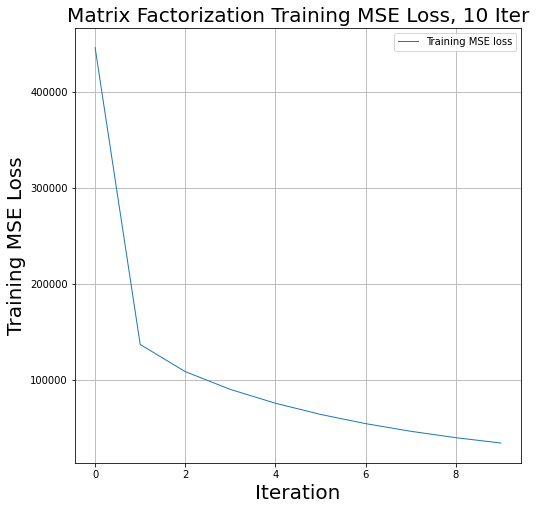

In [80]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, 10), training_loss, label ="Training MSE loss", linewidth=1)
plt.grid()
plt.legend()
plt.ylabel("Training MSE Loss", fontsize =20)
plt.xlabel("Iteration", fontsize=20)
plt.title("Matrix Factorization Training MSE Loss, 10 Iter", fontsize = 20)
plt.plot

In [81]:
min(training_loss)

33876.347215772184

## K means

In [6]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [7]:
sel_hotel_f_from_yue = ['site_name' ,'posa_continent', 'channel','srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market',   'pca_d1', 'pca_d2', 'pca_d3', 'pca_d4', 'pca_d5', 'pca_d6', 'pca_d7', 'pca_d8', 'pca_d9', 'pca_d10', 'pca_d11', 'pca_d12', 'pca_d13', 'pca_d14', 'pca_d15', 'pca_d16', 'pca_d17', 'pca_d18', 'pca_d19']
sel_user_f_from_yue = [ 'user_location_country','user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'cnt', 'is_holiday','plan_time', 'duration_stay', 'travel_month', 'travel_day', 'travel_single']
sel_f_from_yue = sel_hotel_f_from_yue + sel_user_f_from_yue 

y = ['Popularity']

data=pd.read_csv("merged_train_data_addingfeatures_add_Popularity.csv")
data=data.dropna()

X = data[sel_f_from_yue].values
y = data[y].values

In [8]:
print(X.shape) # (190595, 44)
print(y.shape) # (190595, 1)

(190595, 44)
(190595, 1)


## Settings:
no train test split

use inertia and sil score


In [9]:
data[sel_f_from_yue].isna().sum()

site_name                    0
posa_continent               0
channel                      0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
hotel_continent              0
hotel_country                0
hotel_market                 0
pca_d1                       0
pca_d2                       0
pca_d3                       0
pca_d4                       0
pca_d5                       0
pca_d6                       0
pca_d7                       0
pca_d8                       0
pca_d9                       0
pca_d10                      0
pca_d11                      0
pca_d12                      0
pca_d13                      0
pca_d14                      0
pca_d15                      0
pca_d16                      0
pca_d17                      0
pca_d18                      0
pca_d19                      0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id 

In [10]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics
inert_k =[]
sil_k =[]

for k in range(2, 100, 10):
  print("k now is: ", k)
  km = KMeans(n_clusters = k, init = 'k-means++', n_init = 5)
  km.fit(X)
  inert_k.append(km.inertia_)
  sil_k.append(metrics.silhouette_score(X, km.labels_, metric ="euclidean"))


k now is:  2
k now is:  12
k now is:  22
k now is:  32
k now is:  42
k now is:  52
k now is:  62
k now is:  72
k now is:  82
k now is:  92


In [65]:
print(inert_k)

[5453945211930574.0, 229253656029564.56, 120448800164547.03, 94723053806334.88, 78000503590331.19, 65123375413064.01, 56667342707614.19, 50601697668408.44, 46596759895981.484, 42236247355151.19]


In [55]:
print(sil_k)

[0.6198781702775904, 0.4415152300481047, 0.3429792157103806, 0.3024305472728826, 0.3032708295495772, 0.3054223848830767, 0.3044248333119394, 0.3049941276662341, 0.2969574096280541, 0.29465949016718573]


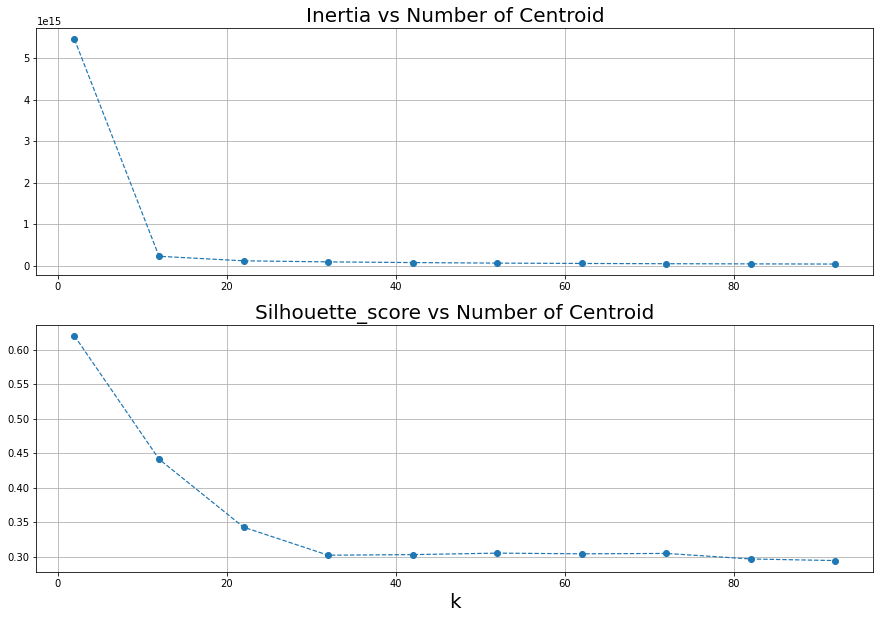

In [67]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
x=np.arange(2,100,10)

plt.plot(x, inert_k,linewidth = 1.2,linestyle='--', marker='o')
plt.title('Inertia vs Number of Centroid', fontsize=20)
plt.grid()

ax2 = plt.subplot(212)
plt.plot(x, sil_k,  linewidth=1.2, linestyle='--', marker='o')
plt.title('Silhouette_score vs Number of Centroid', fontsize=20)
plt.xlabel("k", fontsize=20)
plt.grid()

plt.show()